<img src="header.png" align="left"/>

# Anwendungsbeispiel Import of text data with sentiment classification

In diesem Beispiel werden wir Textdaten behandeln und versuchen die Stimmung eines kurzen Stückes Text zu bestimmen. Damit können zum Beispiel eMails oder Social Media Beiträge gefiltert werden.





- [2] [https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/](https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/)
- [3] https://gdcoder.com/sentiment-clas/
- [4] [https://nlp.stanford.edu/pubs/glove.pdf](https://nlp.stanford.edu/pubs/glove.pdf)


Zitierungen GloVe [1] und Datensatz[2]:
```
[1] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation.

[2] Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher, Learning Word Vectors for Sentiment Analysis, Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, June 2011, Portland, Oregon, USA, Association for Computational Linguistics, http://www.aclweb.org/anthology/P11-1015

```









# Import der Module

In [1]:
#
# Import der Module
#
import os
import logging
import re
import string
from urllib.request import urlretrieve
import tarfile
import zipfile
from glob import glob

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


#
# Abdrehen von Fehlermeldungen
#
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)
simplefilter(action='ignore', category=RuntimeWarning)


#
# Tensorflow und Keras
#
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, SpatialDropout1D
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer


#
# Für GPU Support
#
tflogger = tf.get_logger()
tflogger.setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#
# Einstellen der Grösse von Diagrammen
#
plt.rcParams['figure.figsize'] = [16, 9]


#
# Ausgabe der Versionen
#
print('working on keras version {} on tensorflow {} using sklearn {}'.format ( tf.keras.__version__, tf.version.VERSION, sklearn.__version__ ) )

working on keras version 2.2.4-tf on tensorflow 2.1.0 using sklearn 0.23.2


# Konstanten

In [2]:
#
# Konstanten für Dateien
#
urlDataSource = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
localExtractionFolder = 'data/moviereviews'
localDataArchive = localExtractionFolder + '/aclImdb_v1.tar.gz'
textData = localExtractionFolder + '/aclImdb/'

# Hilfsfunktionen

In [3]:
#
# Laden der Daten von einer URL
#
def download_dataset(url,dataset_file_path,extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if os.path.exists(dataset_file_path):
        print("archive already downloaded.")
    else:
        print("started loading archive from url {}".format(url))
        filename, headers = urlretrieve(url, dataset_file_path)
        print("finished loading archive from url {} to {}".format(url,filename))

def extract_dataset(dataset_file_path, extraction_directory):
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)
    if (dataset_file_path.endswith("tar.gz") or dataset_file_path.endswith(".tgz")):
        tar = tarfile.open(dataset_file_path, "r:gz")
        tar.extractall(path=extraction_directory)
        tar.close()
    elif (dataset_file_path.endswith("tar")):
        tar = tarfile.open(dataset_file_path, "r:")
        tar.extractall(path=extraction_directory)
        tar.close()
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )


# Laden und erster Check

In [4]:
#
# Laden der Daten ausführen
#
download_dataset(urlDataSource,localDataArchive,localExtractionFolder)

archive already downloaded.


In [5]:
#
# Extrahieren der Daten
#
extract_dataset(localDataArchive,localExtractionFolder)

extraction of dataset from data/moviereviews/aclImdb_v1.tar.gz to data/moviereviews done.


# Wie sehen die Daten auf dem Filesystem aus?

<img src="info.png" align="left"/> 

In [6]:
#
# Sammeln der Daten aus den Files
#
def load_texts_labels_from_folders(path, folders):
    print('scanning path {}'.format(path))
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        print('scanning {}'.format(idx))
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int8)

In [7]:
#
# Laden der positiven und negativen Beispiele
#
classes = ['neg','pos']
x_train,y_train = load_texts_labels_from_folders( textData + 'train', classes)
x_test,y_test = load_texts_labels_from_folders( textData + 'test', classes)

scanning path data/moviereviews/aclImdb/train
scanning 0
scanning 1
scanning path data/moviereviews/aclImdb/test
scanning 0
scanning 1


In [8]:
len(x_train),len(y_train),len(x_test),len(y_test)

(25000, 25000, 25000, 25000)

In [9]:
#
# Prüfen des Datentypen
#
(type(x_train),type(y_train))

(list, numpy.ndarray)

In [10]:
#
# Prüfen der Klassen
#
np.unique(y_train)

array([0, 1], dtype=int8)

In [11]:
#
# negative Beispiele
#
for index in range (0,1):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()

I thought the movie (especially the plot) needs a lot of work. The elements of the movie remains westernized and untrue to the attempt of trying to produce an eastern feel in the movie. I'll give three out of many of the flaws of the movie:<br /><br />First, when Shen told Wendy that he would help her study the history of China, I was really happy that the audience would receive some information about Chinese history; but it turns out that the movie did not exactly show Wendy actually studying Chinese history; yet instead, the movie only shows Wendy practicing the method of remembering what she had studied, which frustrated and put me in dismay.<br /><br />Second, which really bothered me, is how the characters kept mentioning about moon cakes -- moon cakes this and moon cakes that and how good it tastes. Yet they didn't really mention the real significance of it. The only they they talked about that had any relevance to the moon cake was the Autumn Festival, which they did not explain

In [12]:
#
# positive Beispiele
#
for index in range (13001,13002):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()


My personal feeling is that you cannot divorce this movie from its political/historical underpinnings like so many (American) reviewers tend to do. This is not about growing up on Main Street, USA. It is about growing up in Yugoslavia at a time when it was torn between the East and the West. Just like the guys are torn between Esther and everybody else, and Esther is torn between the "Tovarish Joe" and the guys. There is shame in certain situations that is lost on an audience that has never lived under Tito. I feel the movie is under-rated and it is too bad we have lost the director. Movies like this make freedom feel more important. It is not just "another Eastern European coming of age film"...it is a sensitive portrayal of teenagers walking a fine line that might eventually lead them to real freedom.
label 1



# Zerlegen der Texte in Worte und Reinigung

In [13]:
#
# Reinigungsfunktion
#
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # convert to lowercase
    sen = sen.lower()
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [14]:
x_train_clean = []
for review in x_train:
    x_train_clean.append(preprocess_text(review))
    
x_test_clean = []
for review in x_test:
    x_test_clean.append(preprocess_text(review))  
    
x_test = x_test_clean
x_train = x_train_clean

In [15]:
for index in range (0,1):
    print(x_train[index])
    print("label {}".format(y_train[index]))
    print()

i thought the movie especially the plot needs lot of work the elements of the movie remains westernized and untrue to the attempt of trying to produce an eastern feel in the movie ll give three out of many of the flaws of the movie first when shen told wendy that he would help her study the history of china was really happy that the audience would receive some information about chinese history but it turns out that the movie did not exactly show wendy actually studying chinese history yet instead the movie only shows wendy practicing the method of remembering what she had studied which frustrated and put me in dismay second which really bothered me is how the characters kept mentioning about moon cakes moon cakes this and moon cakes that and how good it tastes yet they didn really mention the real significance of it the only they they talked about that had any relevance to the moon cake was the autumn festival which they did not explain or go in depth they could have mentioned the myth

# Umwandeln der Worte in Vektoren

In [16]:
#
# Lernen der Umrechnung der Worte in Wortindizes
#
tokenizer = Tokenizer(num_words=5000, lower=True, oov_token='unknwn')
tokenizer.fit_on_texts(x_train)

In [17]:
# 
# Umrechnen der Sätze in Listen von Wortindizes
#
x_train_v = tokenizer.texts_to_sequences(x_train)
x_test_v = tokenizer.texts_to_sequences(x_test)

In [18]:
print(x_train_v[0])

[128, 193, 2, 15, 254, 2, 108, 721, 172, 4, 156, 2, 773, 4, 2, 15, 1251, 1, 3, 1, 5, 2, 575, 4, 261, 5, 2194, 31, 4905, 227, 8, 2, 15, 232, 198, 284, 41, 4, 105, 4, 2, 1481, 4, 2, 15, 80, 50, 1, 565, 4303, 10, 21, 57, 333, 37, 2034, 2, 465, 4, 2563, 11, 61, 627, 10, 2, 297, 57, 3861, 45, 1588, 40, 1578, 465, 16, 7, 495, 41, 10, 2, 15, 116, 20, 603, 117, 4303, 163, 1, 1578, 465, 241, 300, 2, 15, 60, 283, 4303, 1, 2, 4131, 4, 1, 44, 49, 64, 1, 58, 3520, 3, 269, 67, 8, 1, 327, 58, 61, 2582, 67, 6, 83, 2, 99, 807, 4803, 40, 1761, 1, 1761, 1, 9, 3, 1761, 1, 10, 3, 83, 46, 7, 1, 241, 29, 157, 61, 744, 2, 143, 1, 4, 7, 2, 60, 29, 29, 3496, 40, 10, 64, 96, 1, 5, 2, 1761, 4304, 11, 2, 1, 1371, 58, 29, 116, 20, 1233, 38, 137, 8, 1106, 29, 93, 24, 1022, 2, 1, 10, 1, 14, 2, 1761, 4304, 2, 1761, 716, 2, 1, 503, 4, 14, 83, 36, 278, 2916, 726, 1, 3, 250, 57, 1, 4643, 16, 26, 242, 27, 726, 1, 2083, 52, 1, 52, 2, 1482, 14, 2, 4643, 1553, 3447, 33, 2, 1, 1, 1, 1, 317, 2917, 4, 2, 726, 1, 1172, 60, 26, 2

vectorized length mean 222.87924


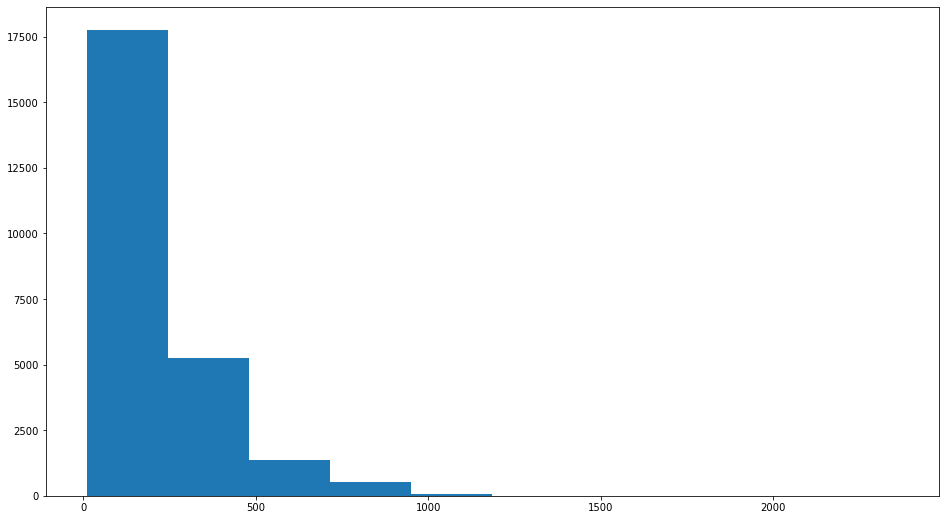

In [19]:
#
# Zählen der Längen der vektorisierten Texte
#
textLength = []
for index in range (0,len(x_train_v)):
    textLength.append(len(x_train_v[index]))

plt.hist(textLength)
lengthArray = np.array(textLength)
print('vectorized length mean {}'.format(np.mean(lengthArray)))

In [20]:
#
#
#
vocab_size = len(tokenizer.word_index) + 1
print('count of words {}'.format(vocab_size))

count of words 74220


In [21]:
maxlen = 200

x_train = pad_sequences(x_train_v, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test_v, padding='post', maxlen=maxlen)

# Umrechnung in einen dichten Vektorraum (glove)

In [22]:
gloveUrl = 'http://nlp.stanford.edu/data/glove.6B.zip'
gloveExtractionFolder = 'data/glove'
gloveDataArchive = gloveExtractionFolder + '/glove.6B.zip'
gloveData = gloveExtractionFolder + '/' + 'glove.6B.100d.txt'

gloveDims = 100

In [23]:
def unzip_dataset(dataset_file_path, extraction_directory):  
    if (not os.path.exists(extraction_directory)):
        os.makedirs(extraction_directory)        
    zip = zipfile.ZipFile(dataset_file_path)
    zip.extractall(path=extraction_directory)        
    print("extraction of dataset from {} to {} done.".format(dataset_file_path,extraction_directory) )

In [24]:
#
# Laden der Daten ausführen
#
if ( not os.path.exists(gloveData)):
    download_dataset(gloveUrl,gloveDataArchive,gloveExtractionFolder)

In [25]:
if ( not os.path.exists(gloveData)):
    unzip_dataset(gloveDataArchive,gloveExtractionFolder)

In [26]:
#
# Laden der GloVe Vektoren für die Worte
#
embeddings_dictionary = dict()
glove_file = open(gloveData, encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [27]:
#
# Erstellen einer Matrix für die Umrechung von Worten in die dichten Vektoren über
# die Wortindizes
#
embedding_matrix = np.zeros((vocab_size, gloveDims))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [28]:
print(embedding_matrix.shape)

(74220, 100)


# Erstellen eines Modelles

In [29]:
def createNNModel():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, gloveDims, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [30]:
model = createNNModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          7422000   
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2000100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 9,422,201
Trainable params: 2,000,201
Non-trainable params: 7,422,000
_________________________________________________________________
None


In [31]:
history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 3s 138us/sample - loss: 0.7155 - acc: 0.5995 - val_loss: 0.9752 - val_acc: 0.1724
Epoch 2/30
20000/20000 [==============================] - 2s 77us/sample - loss: 0.5856 - acc: 0.6901 - val_loss: 0.6889 - val_acc: 0.6186
Epoch 3/30
20000/20000 [==============================] - 2s 85us/sample - loss: 0.5128 - acc: 0.7599 - val_loss: 0.6981 - val_acc: 0.6286
Epoch 4/30
20000/20000 [==============================] - 2s 77us/sample - loss: 0.4568 - acc: 0.7986 - val_loss: 0.7081 - val_acc: 0.6322
Epoch 5/30
20000/20000 [==============================] - 2s 77us/sample - loss: 0.4171 - acc: 0.8202 - val_loss: 0.7471 - val_acc: 0.6274
Epoch 6/30
20000/20000 [==============================] - 2s 77us/sample - loss: 0.3758 - acc: 0.8483 - val_loss: 0.8358 - val_acc: 0.5996
Epoch 7/30
20000/20000 [==============================] - 2s 79us/sample - loss: 0.3382 - acc: 0.8654 - val_loss: 0.

In [32]:
score = model.evaluate(x_test, y_test, verbose=1)

25000/25000 [==============================] - 3s 123us/sample - loss: 1.1750 - acc: 0.7145


In [33]:
print("test loss:", score[0])
print("test accuracy:", score[1])

test loss: 1.1749985257434845
test accuracy: 0.71452


In [34]:
def plotResults(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

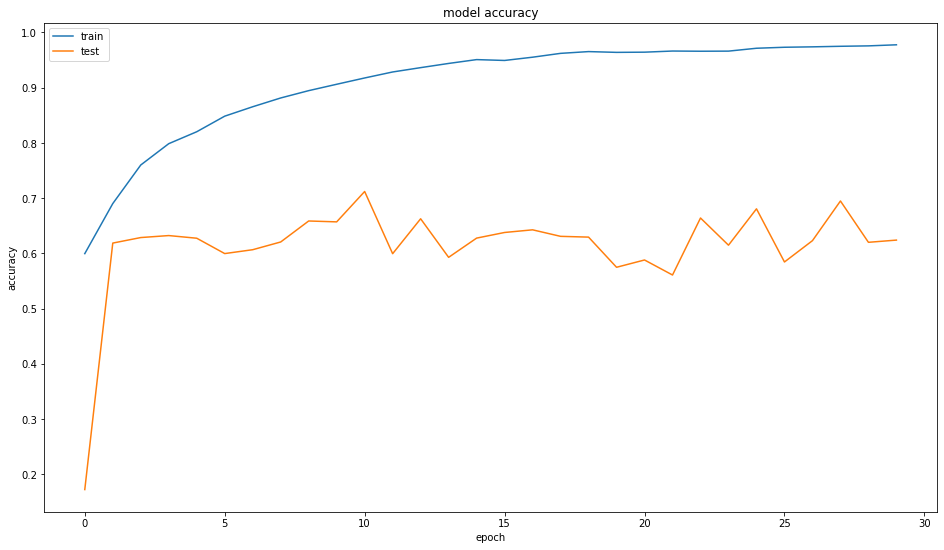

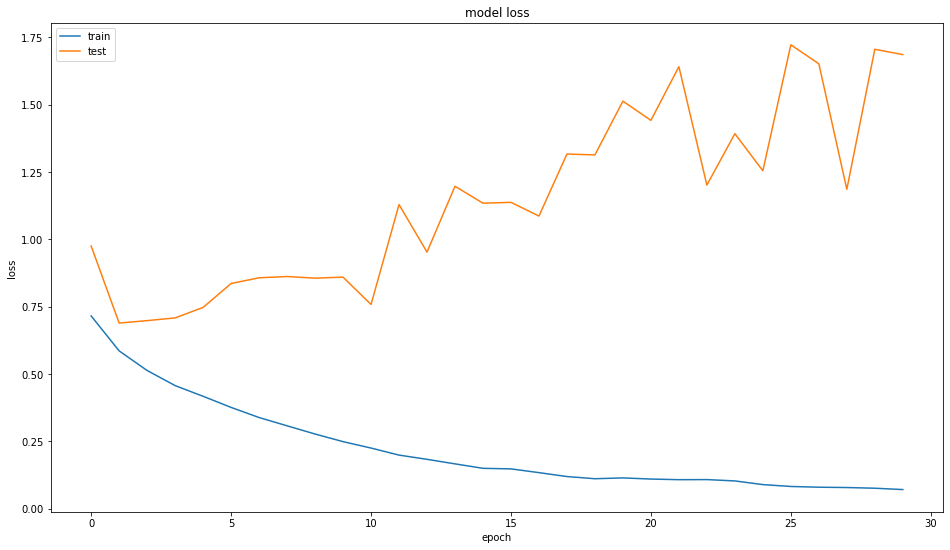

In [35]:
plotResults(history)

# Verbessertes Modell

Beschreibung von LSTMs: https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47

Hinweise für bessere Modelle gefunden auf Kaggle [https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras](https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras).

<img src="info.png" align="left"/>

In [36]:
def createLSTMModel():
    model = Sequential()
    model.add(Embedding(vocab_size, gloveDims, weights=[embedding_matrix], input_length=maxlen , trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

In [37]:
model = createLSTMModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          7422000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 150)               150600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 7,572,751
Trainable params: 150,751
Non-trainable params: 7,422,000
_________________________________________________________________
None


In [38]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)
score = model.evaluate(x_test, y_test, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 71s 4ms/sample - loss: 0.6555 - acc: 0.6294 - val_loss: 0.9719 - val_acc: 0.1162
Epoch 2/10
20000/20000 [==============================] - 68s 3ms/sample - loss: 0.6426 - acc: 0.6439 - val_loss: 0.9893 - val_acc: 0.1422
Epoch 3/10
20000/20000 [==============================] - 67s 3ms/sample - loss: 0.6328 - acc: 0.6575 - val_loss: 1.1662 - val_acc: 0.1020
Epoch 4/10
20000/20000 [==============================] - 69s 3ms/sample - loss: 0.6305 - acc: 0.6564 - val_loss: 0.7421 - val_acc: 0.6062
Epoch 5/10
20000/20000 [==============================] - 67s 3ms/sample - loss: 0.6021 - acc: 0.6758 - val_loss: 0.7121 - val_acc: 0.3728
Epoch 6/10
20000/20000 [==============================] - 69s 3ms/sample - loss: 0.6438 - acc: 0.6417 - val_loss: 0.8099 - val_acc: 0.2582
Epoch 7/10
20000/20000 [==============================] - 58s 3ms/sample - loss: 0.6275 - acc: 0.6600 - val_loss: 0.9

In [39]:
print("test loss:", score[0])
print("test accuracy:", score[1])

test loss: 0.6349217654228211
test accuracy: 0.72476


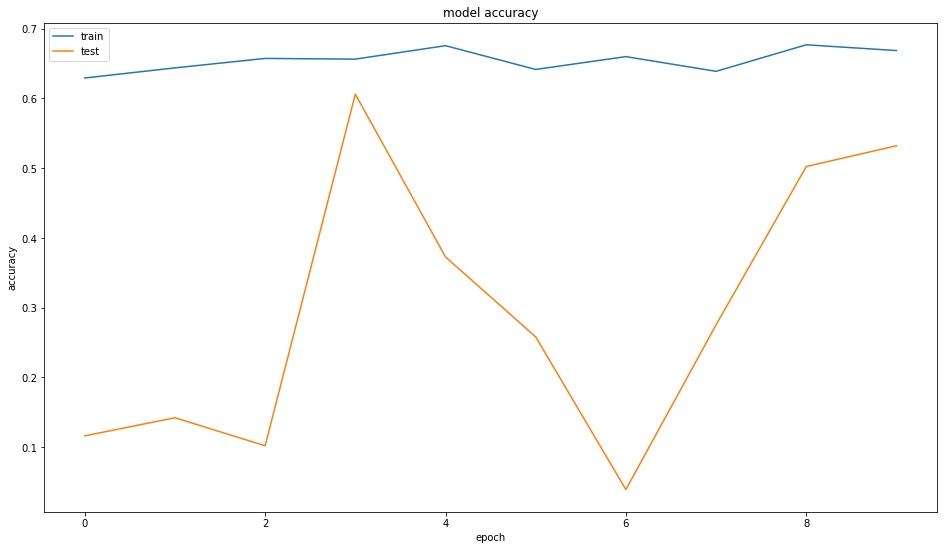

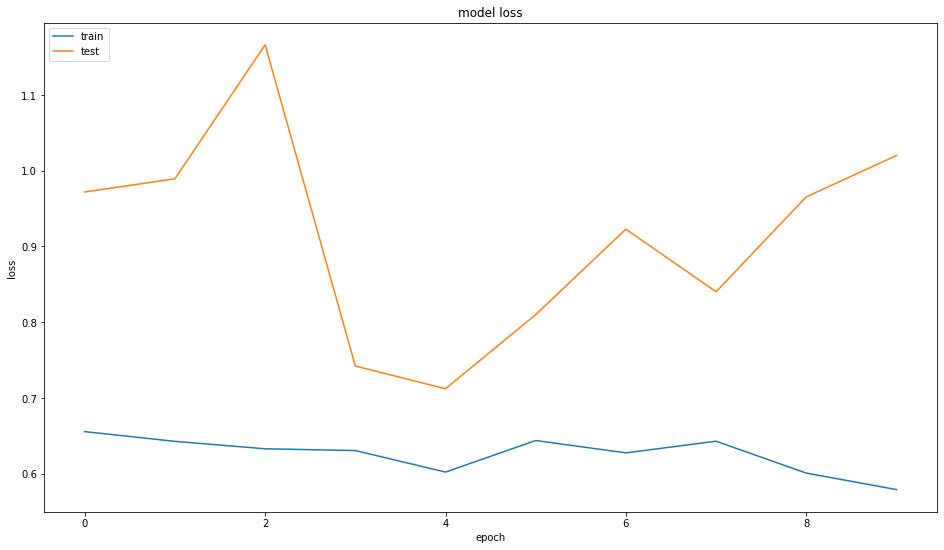

In [40]:
plotResults(history)

# Test mit neuen Daten

In [42]:
def sentiment(text):
    
    instance = tokenizer.texts_to_sequences(text)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]
    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)
    sentiment = model.predict(instance)
    
    comment = 'meh'
    if sentiment > 0.85:
        comment = 'very good'
    elif sentiment > 0.75:
        comment = 'good'
    elif sentiment > 0.50:
        comment = 'moderate'
    return sentiment,comment

In [43]:
test1 = "I simply don't like this film. I does not reach to any expectations."
print ( sentiment(test1))

(array([[0.61628145]], dtype=float32), 'moderate')


In [44]:
test1 = "I hate this film. It is the worst garbage on earth."
print ( sentiment(test1))

(array([[0.61628157]], dtype=float32), 'moderate')


# Weiterführende Schritte


Stimmungsanalyse für Deutsch [https://machine-learning-blog.de/2019/06/03/stimmungsanalyse-sentiment-analysis-auf-deutsch-mit-python/](https://machine-learning-blog.de/2019/06/03/stimmungsanalyse-sentiment-analysis-auf-deutsch-mit-python/)

Anleitung für Zugriff auf twitter API [https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/](https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/)

<img src="info.png" align="left"/>
